In [ ]:
# install dependencies
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!pip3 install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 626 kB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.1-py3-none-any.whl size=701378 sha256=db77b9556e06d5e650d802397b7d0d875332110131ea7a694e5fba06fdb31908
  Stored in directory: /root/.cache/pip/wheels/e3/33/04/6723848e46f0f1ebe794bb329b7c761c3329a0d7ffade99da7
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple,

In [ ]:
import torch
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# enviroment
import gym

env = gym.make('LunarLander-v2')
print("Action space size:", env.action_space)
print("State space size: ", env.observation_space.shape[0])
state_size = 8  #TODO: find observation size
action_size = 4 #TODO: find action size

Action space size: Discrete(4)
State space size:  8


In [ ]:
# experience replay
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)

    def store_trans(self, s, a, sp, r, done):
        # TODO: store new transition in memory
        exp = Transition(s, a, r, sp, done)
        self.memory.append(exp)
        pass

    def sample(self, batch_size):
        # TODO: take RANDOM sample from memory
        sample_exp = random.sample(self.memory, batch_size)
        states = torch.from_numpy(np.vstack([exp.state for exp in sample_exp if exp is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([exp.action for exp in sample_exp if exp is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in sample_exp if exp is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in sample_exp if exp is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([exp.done for exp in sample_exp if exp is not None]).astype(np.uint8)).float().to(
            device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [ ]:
# DQN
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()
        # TODO: define the architecture
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        # NOTE: input=observation/state, output=action
        pass

    def forward(self, x):
        # TODO: forward propagation
        """Build a network that maps state -> action values."""
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)
        # NOTE: use ReLu for activation function in all layers
        # NOTE: last layer has no activation function (predict action)
        pass

## DQN

In [ ]:
# DQN agent
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=5e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)

        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)


    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE:

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return
        # transition batch
        #batch = Transition(*zip(*self.experience_replay.sample(self.batch_size))) #gives error for my code
        #batch = random.sample(self.experience_replay.memory, k=self.batch_size)
        bbatch=agent.experience_replay.sample(self.batch_size)
        batch = Transition(bbatch[0],bbatch[1],bbatch[3],bbatch[2],bbatch[4])
        """
        state_batch = torch.from_numpy(np.vstack([e.state for e in batch if e is not None])).float().to(device)
        action_batch = torch.tensor(np.vstack([e.action for e in batch if e is not None])).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack([e.next_state for e in batch if e is not None])).float().to(device)
        reward_batch = torch.tensor(np.vstack([e.reward for e in batch if e is not None])).float().to(device)
        done_batch = torch.tensor(np.vstack([e.done for e in batch if e is not None]).astype(np.uint8)).float().to(device)
        """
        state_batch = (batch.state.cpu()).float().to(device)
        action_batch =(batch.action.cpu()).long().to(device)
        next_state_batch = (batch.next_state.cpu()).float().to(device)
        reward_batch = (batch.reward.cpu()).float().to(device)
        done_batch = (batch.done.cpu()).to(device)
        
        # calculate loss w.r.t DQN algorithm

        # STEP1
        # TODO: compute the expected Q values [y]
        q_expected = self.value_net(state_batch).gather(1, action_batch)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        Q_max = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        q_table = reward_batch + self.gamma * Q_max * (1 - done_batch)
        # STEP3
        # TODO: compute mse loss
        loss = F.mse_loss(q_expected, q_table)

        # TODO: optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # NOTE: DON'T forget to set the gradients to zeros

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(agent.value_net.state_dict(), fname + ".pth")

    def load(self, fname, device):
        # TODO: load checkpoint
        agent.value_net.load_state_dict(torch.load(fname + ".pth"))
        

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.99
eps_end = 0.01

In [ ]:
# training phase
# TODO: create agent
bs=64
agent = DQNAgent(state_size=8, action_size=4, batch_size=bs)
crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
z=1
# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    state = env.reset()
    cr = 0 # episode cummulative rewards
    done = 0
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state,action,reward,next_state,done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        cr += reward
        state = next_state
    # TODO: decay epsilon
    eps = max(eps_decay_rate*eps,eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs_recent.append(cr)       
    crs[i_episode-1] = cr             
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      agent.save("ckpt" + str(i_episode//50))
      print("\rCheckpoint",i_episode//50, "saved")
    #print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))
    if (np.mean(crs_recent) and z) >=200:
      print("\nSolved")
      z=0
      #break

Episode 25	Average Reward: -179.79	Epsilon: 0.78
Checkpoint 1 saved
Episode 50	Average Reward: -95.54	Epsilon: 0.61
Episode 75	Average Reward: -79.98	Epsilon: 0.47
Checkpoint 2 saved
Episode 100	Average Reward: -62.30	Epsilon: 0.37
Episode 125	Average Reward: 16.02	Epsilon: 0.28
Checkpoint 3 saved
Episode 150	Average Reward: 76.03	Epsilon: 0.22
Episode 175	Average Reward: 35.79	Epsilon: 0.17
Checkpoint 4 saved
Episode 200	Average Reward: 142.14	Epsilon: 0.13
Episode 225	Average Reward: 79.54	Epsilon: 0.10
Checkpoint 5 saved
Episode 250	Average Reward: 154.96	Epsilon: 0.08


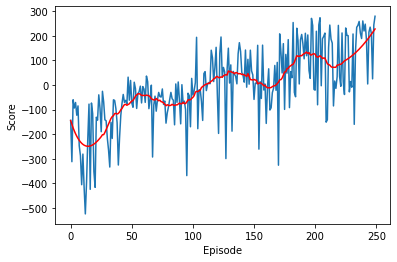

In [ ]:
# plot the scores
# batch 32
import matplotlib.pyplot as plt
plt.figure()
plt.plot(crs[0:i_episode])
plt.ylabel('Score')
plt.xlabel('Episode')
from scipy.signal import savgol_filter
yhat = savgol_filter(crs[0:i_episode], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat,color="red")
plt.show()


In [ ]:
# training phase
# TODO: create agent
bs=64
agent = DQNAgent(state_size=8, action_size=4, batch_size=bs)
crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
z=1
# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    state = env.reset()
    cr = 0 # episode cummulative rewards
    done = 0
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state,action,reward,next_state,done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        cr += reward
        state = next_state
    # TODO: decay epsilon
    eps = max(eps_decay_rate*eps,eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs_recent.append(cr)       
    crs[i_episode-1] = cr             
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      agent.save("ckpt" + str(i_episode//50))
      print("\rCheckpoint",i_episode//50, "saved")
    #print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))
    if (np.mean(crs_recent) and z) >=200:
      print("\nSolved")
      z=0
      #break

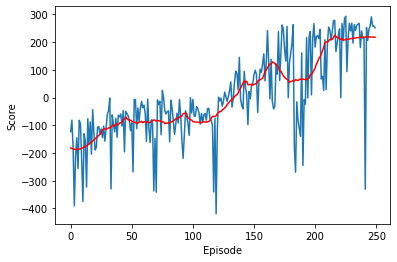

In [ ]:
# plot the scores
# batch 64
import matplotlib.pyplot as plt
plt.figure()
plt.plot(crs[0:i_episode])
plt.ylabel('Score')
plt.xlabel('Episode')
from scipy.signal import savgol_filter
yhat = savgol_filter(crs[0:i_episode], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat,color="red")
plt.show()

In [ ]:
from google.colab import files
files.download("ckpt1.pth")
files.download("ckpt2.pth")
files.download("ckpt3.pth")
files.download("ckpt4.pth")
files.download("ckpt5.pth")

In [ ]:
# training phase
# TODO: create agent
bs=128
agent = DQNAgent(state_size=8, action_size=4, batch_size=bs)
crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards
z=1
# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    state = env.reset()
    cr = 0 # episode cummulative rewards
    done = 0
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state,action,reward,next_state,done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        cr += reward
        state = next_state
    # TODO: decay epsilon
    eps = max(eps_decay_rate*eps,eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs_recent.append(cr)       
    crs[i_episode-1] = cr             
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      agent.save("ckpt" + str(i_episode//50))
      print("\rCheckpoint",i_episode//50, "saved")
    #print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))
    if (np.mean(crs_recent) and z) >=200:
      print("\nSolved")
      z=0
      #break

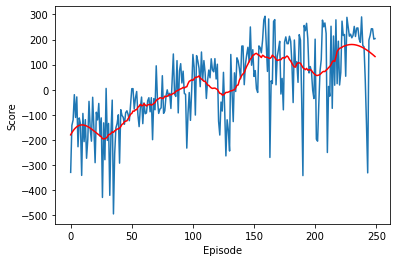

In [ ]:
# plot the scores
# batch 128
import matplotlib.pyplot as plt
plt.figure()
plt.plot(crs[0:i_episode])
plt.ylabel('Score')
plt.xlabel('Episode')
from scipy.signal import savgol_filter
yhat = savgol_filter(crs[0:i_episode], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat,color="red")
plt.show()

In [ ]:
import copy
dqn_crs = copy.deepcopy(crs[0:i_episode])

## DDQN

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
tau=1e-3
class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=5e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.replay_buffer = ExperienceReplay(buffer_size)

        # networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)
        # NOTE: target network parameters DOSEN'T update with optimizer

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.value_net.eval()
        with torch.no_grad():
            action_values = self.value_net(state)
        self.value_net.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE:
        pass

    def update_params(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        # transition batch
        
        """ # gives error for my code
        batch = Transition(*zip(*self.replay_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)
        """
        bbatch=agent.replay_buffer.sample(self.batch_size)
        batch = Transition(bbatch[0],bbatch[1],bbatch[3],bbatch[2],bbatch[4])
        state_batch = (batch.state.cpu()).float().to(device)
        action_batch =(batch.action.cpu()).long().to(device)
        next_state_batch = (batch.next_state.cpu()).float().to(device)
        reward_batch = (batch.reward.cpu()).float().to(device)
        done_batch = (batch.done.cpu()).to(device)
        batch = random.sample(self.replay_buffer.memory, k=self.batch_size)

        # calculate loss w.r.t DQN algorithm

        # STEP1
        # TODO: compute the expected Q values [y]
        q_expected = self.value_net(state_batch).gather(1, action_batch)

        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        with torch.no_grad():
                next_actions = self.value_net(next_state_batch).argmax(-1, keepdim=True)
                maxQ = self.target_value_net(next_state_batch).gather(-1, next_actions)
                target = reward_batch+self.gamma*maxQ*(1-done_batch)
        # STEP3
        # TODO: compute mse loss
        loss = F.mse_loss(q_expected, target)

        # TODO: optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # NOTE: DON'T forget to set the gradients to zeros
        self.update_target_network()

    def update_target_network(self):
        # TODO: copy main network parameters to target network parameters
        for target_param, local_param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
          target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    def save(self, fname):
        # TODO: save checkpoint
        torch.save(agent.value_net.state_dict(), fname + ".pth")

    def load(self, fname, device):
        # TODO: load checkpoint
        agent.value_net.load_state_dict(torch.load(fname + ".pth"))

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.99
eps_end = 0.01

In [ ]:
# training phase

# TODO: create agent
bs=64
agent = DDQNAgent(state_size=8, action_size=4, batch_size=bs)
crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    state = env.reset()
    done = 0
    cr = 0 # episode cummulative rewards
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        # TODO: store transition in experience replay
        agent.replay_buffer.store_trans(state,action,reward,next_state,done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        cr += reward
        state = next_state
    # TODO: decay epsilon
    eps = max(eps_end, eps_decay_rate*eps)
    crs_recent.append(cr)       
    crs[i_episode-1] = cr             
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
      agent.save("ckpt" + str(i_episode//50))
      print("\nCheckpoint",i_episode//50, "saved")
    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -174.03	Epsilon: 0.78
Episode 49	Average Reward: -153.58	Epsilon: 0.61
Checkpoint 1 saved
Episode 50	Average Reward: -143.67	Epsilon: 0.61
Episode 75	Average Reward: -98.76	Epsilon: 0.47
Episode 99	Average Reward: -120.88	Epsilon: 0.37
Checkpoint 2 saved
Episode 100	Average Reward: -121.90	Epsilon: 0.37
Episode 125	Average Reward: -21.90	Epsilon: 0.28
Episode 149	Average Reward: 76.70	Epsilon: 0.22
Checkpoint 3 saved
Episode 150	Average Reward: 76.52	Epsilon: 0.22
Episode 175	Average Reward: 100.73	Epsilon: 0.17
Episode 199	Average Reward: 158.09	Epsilon: 0.14
Checkpoint 4 saved
Episode 200	Average Reward: 159.54	Epsilon: 0.13
Episode 225	Average Reward: 238.12	Epsilon: 0.10
Episode 249	Average Reward: 228.24	Epsilon: 0.08
Checkpoint 5 saved
Episode 250	Average Reward: 219.82	Epsilon: 0.08


In [ ]:
from google.colab import files
files.download("ckpt1.pth")
files.download("ckpt2.pth")
files.download("ckpt3.pth")
files.download("ckpt4.pth")
files.download("ckpt5.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

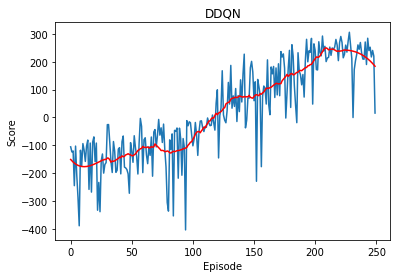

In [ ]:
# plot the scores
# batch 64
import matplotlib.pyplot as plt
plt.figure()
plt.plot(crs[0:i_episode])
plt.ylabel('Score')
plt.xlabel('Episode')
from scipy.signal import savgol_filter
yhat = savgol_filter(crs[0:i_episode], 51, 3) # window size 51, polynomial order 3
plt.title("DDQN")
plt.plot(yhat,color="red")
plt.show()

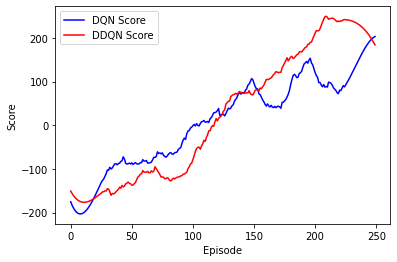

In [ ]:
# plot the scores
# batch 64
from scipy.signal import savgol_filter
yhat1 = savgol_filter(dqn_crs[0:i_episode], 51, 3) # window size 51, polynomial order 3
yhat2 = savgol_filter(crs[0:i_episode], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat1,color="blue")
plt.plot(yhat2,color="red")
plt.legend(["DQN Score","DDQN Score"])
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()